## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib.patches import ConnectionPatch
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

/home/macteos/Documents/Code/Kaggle Projects/Housing Prices/.venv/lib/python3.12/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [ ]:
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

In [ ]:
def preprocess_data(df_train, df_test):
    label_enc = LabelEncoder()
    label_cols = ['person_home_ownership', 'loan_grade', 'cb_person_default_on_file']
    for col in label_cols:
        df_train[col] = label_enc.fit_transform(df_train[col])
        df_test[col] = label_enc.transform(df_test[col])
    df_train = pd.get_dummies(df_train, columns=['loan_intent'], drop_first=True)
    df_test = pd.get_dummies(df_test, columns=['loan_intent'], drop_first=True)
    target_col = 'loan_status'
    train_columns = df_train.drop(columns=[target_col]).columns
    df_test = df_test.reindex(columns=train_columns, fill_value=0)
    return df_train, df_test

df_train_processed, df_test_processed = preprocess_data(df_train, df_test)

In [ ]:
df_train = df_train_processed
df_test = df_test_processed

df_train.shape, df_test.shape

((58645, 16), (39098, 15))

In [ ]:
y = df_train['loan_status']
df_train = df_train.drop(['loan_status'],axis=1)
X = df_train

In [ ]:
scaler = StandardScaler()
scaled_train_data = df_train
scaled_test_data = df_test

## Model Training

In [ ]:
lgb_params = {
    'objective': 'binary',
        'n_estimators': 3000,
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'random_state': 42,
        'learning_rate':0.0322942967545754,
        'num_leaves': 24,
        'max_depth': 15,
        'min_data_in_leaf': 25,
        'feature_fraction': 0.6236144085285287,
        'bagging_fraction': 0.9596685778433888,
        'bagging_freq': 3,
        'verbose' : -1
}

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    X_train, X_val = scaled_train_data.iloc[train_idx], scaled_train_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    lgbm_model = LGBMClassifier(**lgb_params)
    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='auc')

    lgbm_fold_preds = lgbm_model.predict_proba(X_val)[:, 1]
    lgbm_fold_test_preds = lgbm_model.predict_proba(scaled_test_data)[:, 1]
    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits

overall_metric_lgbm = roc_auc_score(lgbm_true_labels, lgbm_predictions)
print("Overall AUC (LGBMClassifier):", overall_metric_lgbm)

Overall AUC (LGBMClassifier): 0.9562025439130687


## Model Examination

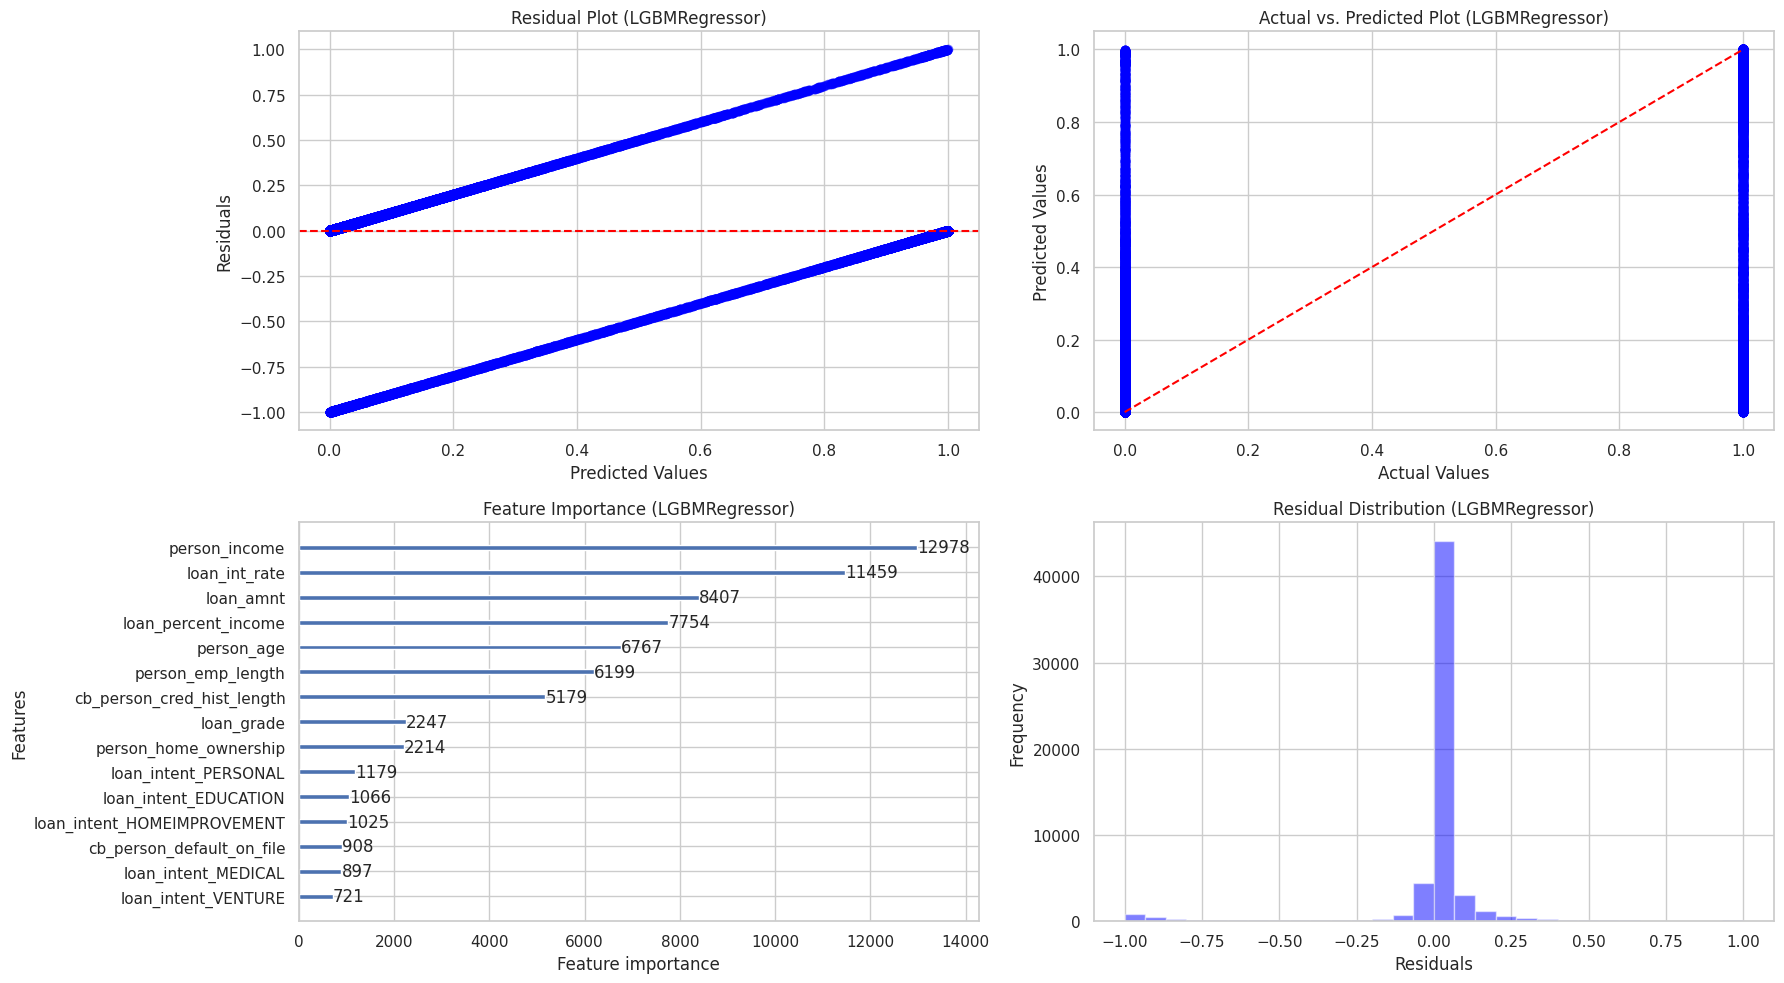

In [ ]:
from lightgbm import plot_importance

lgbm_residuals = lgbm_predictions - lgbm_true_labels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

axes[0, 0].scatter(lgbm_predictions, lgbm_residuals, color='blue', alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residual Plot (LGBMRegressor)')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True)


axes[0, 1].scatter(lgbm_true_labels, lgbm_predictions, color='blue', alpha=0.5)
axes[0, 1].plot([min(lgbm_true_labels), max(lgbm_true_labels)], [min(lgbm_true_labels), max(lgbm_true_labels)], color='red', linestyle='--')
axes[0, 1].set_title('Actual vs. Predicted Plot (LGBMRegressor)')
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].grid(True)

plot_importance(lgbm_model, ax=axes[1, 0], figsize=(10, 6))
axes[1, 0].set_title('Feature Importance (LGBMRegressor)')

axes[1, 1].hist(lgbm_residuals, bins=30, color='blue', alpha=0.5)
axes[1, 1].set_title('Residual Distribution (LGBMRegressor)')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)
plt.tight_layout()
plt.show()

## Submitting results

In [ ]:
df_sub = pd.read_csv('../data/raw/sample_submission.csv')
df_sub.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


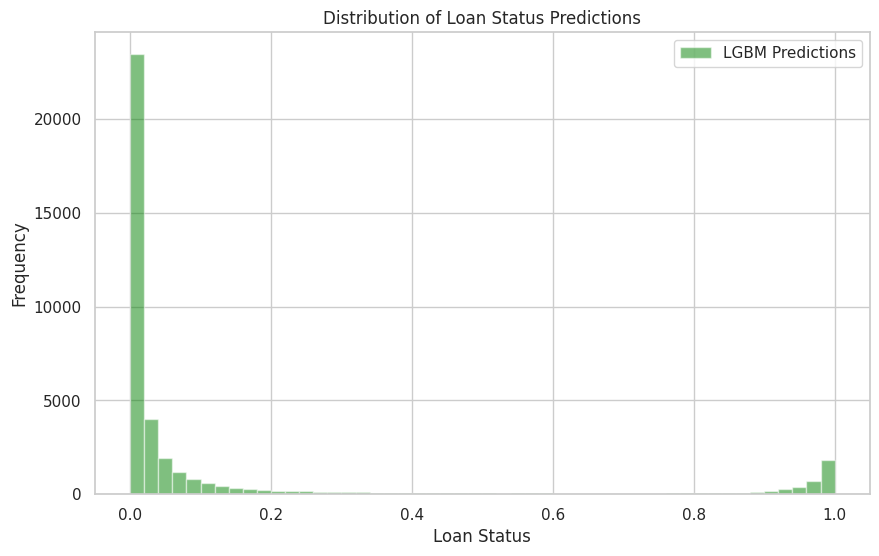

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(lgbm_test_predictions, bins=50, alpha=0.5, color='green', label='LGBM Predictions')
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Status Predictions')
plt.legend()
plt.show()

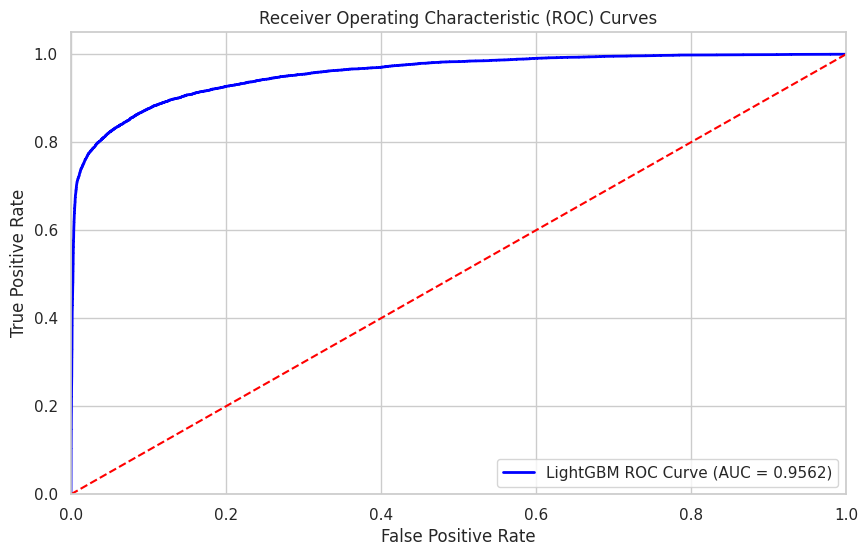

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_lgbm, tpr_lgbm, _ = roc_curve(lgbm_true_labels, lgbm_predictions)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='blue', lw=2, label=f'LightGBM ROC Curve (AUC = {roc_auc_lgbm:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_sub['loan_status'] = lgbm_test_predictions
df_sub.head()

,id,loan_status
0,58645,0.999006
1,58646,0.006040
2,58647,0.832397
3,58648,0.006411
4,58649,0.044484


In [ ]:
df_sub.to_csv('../results/submission.csv', index=False)